In [1]:
import re
import glob
import os

# move .out files to correct location

In [59]:
# folders = ["vzero","vpoint1","vpoint3"]
folders = ["point125","point25","point5","point75"]
# folders = [""]
root_dir = "../SHARCNET/Results/single/ddpg/64_64_NN/old/"
algorithm_lib = "baseline"
all_out_file = {}
for folder in folders:
    visitor_log_file = glob.glob(root_dir+folder+"/*.out", recursive=False)
    print("{}: {} files found".format(folder,len(visitor_log_file)))
    for log_file in visitor_log_file:
        print(log_file)
    all_out_file[folder] = visitor_log_file

point125: 0 files found
point25: 0 files found
point5: 0 files found
point75: 0 files found


In [38]:
def find_directory(file, algorithm_lib):
    
    if algorithm_lib == "spinup":
        line_starter = "Logging data to /home"
    else:
        line_starter = "Logging to /home"

    directory = None
    with open(file,"r") as file_in:
        for line in file_in:
            if line.strip():# not empty line    
                x = re.search(line_starter, line)
                if x is not None:
                    if algorithm_lib == "spinup":
                        directory = line.split("/")[-4]
                    else:
                        directory = line.split("/")[-2]
                    break
    return directory

In [39]:
# Move .out file into correct folder

for folder, files in all_out_file.items():
    print(folder)
    for f in files:
        currdir = f.split("\\")[0]
        file_name = f.split("\\")[1]
        mode = file_name.split("_")[1]
        if mode == "sara":
            mode = "SARA"
        elif mode == "pla":
            mode = "PLA"
        else:
            mode = "Random"
        
        if mode =="Random":
            datedir = find_directory(f, "baseline")
        else:
            datedir = find_directory(f, algorithm_lib)
        
        if datedir is not None:
            new_dir = os.path.join(currdir, mode, datedir, file_name)
            os.rename(f, new_dir)
            print("Move to {}".format(new_dir))
        else:
            print("Fail to move {}".format(f))
        
            
            


Fail to move ../SHARCNET/Results/multi/aug_obs/ddpg/new\s_PLA_21149909.out
Fail to move ../SHARCNET/Results/multi/aug_obs/ddpg/new\s_PLA_21150143.out


# Convert .out to CSV

In [40]:
def out_to_csv(outfile, directory):
    f_in = open(outfile, "r")
    f_out = open(directory + "/visitor_log.csv","w")
    cnt = 0
    # skip lines in the header
    for _ in range(300):
        line = f_in.readline()
        if 'Loading' in line:
            cnt += 1
        if cnt >= 25:
            break;

    # save into CSV
    title = "Time,Location_x_1,Location_y_1,Location_z_1,Destination_x_1,Destination_y_1,Destination_z_1,Distance_1,"+ \
            "Location_x_2,Location_y_2,Location_z_2,Destination_x_2,Destination_y_2,Destination_z_2,Distance_2,"+ \
            "Location_x_3,Location_y_3,Location_z_3,Destination_x_3,Destination_y_3,Destination_z_3,Distance_3,"+ \
            "Location_x_4,Location_y_4,Location_z_4,Destination_x_4,Destination_y_4,Destination_z_4,Distance_4,"+ \
            "Location_x_5,Location_y_5,Location_z_5,Destination_x_5,Destination_y_5,Destination_z_5,Distance_5"+"\n"
    f_out.write(title)
    for line in f_in:
        if line.strip():# not empty line    

            x = re.search("^\d+(\.\d{1,2})", line)
            if x is not None:
                f_out.write(line.replace('(','').replace(')',''))

    f_in.close()
    f_out.close()
    return directory + "/visitor_log.csv"

In [60]:
all_out_file = {}
modes = ["PLA", "SARA", "Random"]
for folder in folders:
    for mode in modes:
        
        visitor_log_file = glob.glob(root_dir+folder+"/"+mode+"/**/*.out", recursive=True)
        print("{}: {} {} files found".format(folder,mode,len(visitor_log_file)))
        for out_file in visitor_log_file:
            print(out_file)
            csv_dir = os.path.join(out_file.split("\\")[0], out_file.split("\\")[1])
            csv_file_dir = out_to_csv(out_file, csv_dir)
            print("convert to: {}".format(csv_file_dir))

point125: Random 2 files found
../SHARCNET/Results/single/ddpg/64_64_NN/old/point125/Random\2019-09-04-233003-0\s_random_19012744ob.out
convert to: ../SHARCNET/Results/single/ddpg/64_64_NN/old/point125/Random\2019-09-04-233003-0/visitor_log.csv
../SHARCNET/Results/single/ddpg/64_64_NN/old/point125/Random\2019-09-04-233006-0\s_random_19021118ob.out
convert to: ../SHARCNET/Results/single/ddpg/64_64_NN/old/point125/Random\2019-09-04-233006-0/visitor_log.csv
point25: Random 2 files found
../SHARCNET/Results/single/ddpg/64_64_NN/old/point25/Random\2019-09-04-235330-0\s_random_19012749ob.out
convert to: ../SHARCNET/Results/single/ddpg/64_64_NN/old/point25/Random\2019-09-04-235330-0/visitor_log.csv
../SHARCNET/Results/single/ddpg/64_64_NN/old/point25/Random\2019-09-04-235334-0\s_random_19022681ob.out
convert to: ../SHARCNET/Results/single/ddpg/64_64_NN/old/point25/Random\2019-09-04-235334-0/visitor_log.csv
point5: Random 2 files found
../SHARCNET/Results/single/ddpg/64_64_NN/old/point5/Random

# Plot visitor positions

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
import matplotlib.patches as patches
import matplotlib as mpl

def plot_scene(ax=None):
    nodes_position = pd.read_csv("NodePosition.csv")
    if ax is None:
        fig = plt.figure(figsize=(12.5,7.5))
        ax = fig.add_subplot(111)
    
#     ir_coverages = []
    for i in range(nodes_position.shape[0]):
        ir = patches.Rectangle((-0.1,0), 0.2, 2, color="blue",  alpha=0.20)
        T = mpl.transforms.Affine2D().rotate_deg(-180+(360-nodes_position.iloc[i]['angle'])) + mpl.transforms.Affine2D().translate(nodes_position.iloc[i]['x'], nodes_position.iloc[i]['z']) + ax.transData
        ir.set_transform(T)
        ax.add_patch(ir)
    plt.scatter(nodes_position['x'], nodes_position['z'])
    plt.grid(True)
    plt.ylim(-7.5, 7.5)
    plt.xlim(-12.5,12.5)
    return ax

import seaborn
from matplotlib.colors import LogNorm
def heat_map(resolution, data_x, data_z, axe=None):
    bins_x = np.linspace(-12.5,12.5,resolution[0]+1)
    bins_z = np.linspace(-7.5,7.5,resolution[1]+1)
    x_discretized = pd.cut(data_x,bins=bins_x,labels=np.linspace(0,resolution[0]-1,resolution[0],dtype=np.int32))
    z_discretized = pd.cut(data_z,bins=bins_z,labels=np.linspace(0,resolution[0]-1,resolution[0],dtype=np.int32))
    activity_map = np.zeros(resolution)
    for i in range(len(x_discretized)):
        position = (z_discretized[i],x_discretized[i])
        activity_map[position] += 1
    
    ax = seaborn.heatmap(activity_map, cmap="YlGnBu", ax=axe)
    ax.invert_yaxis()
    return activity_map, ax

In [61]:
visitor_data = pd.read_csv("../SHARCNET/Results/single/ddpg/64_64_NN/old/point75/Random/2019-09-06-030102-0/visitor_log.csv", sep=',')
print(visitor_data.shape)

(244994, 36)


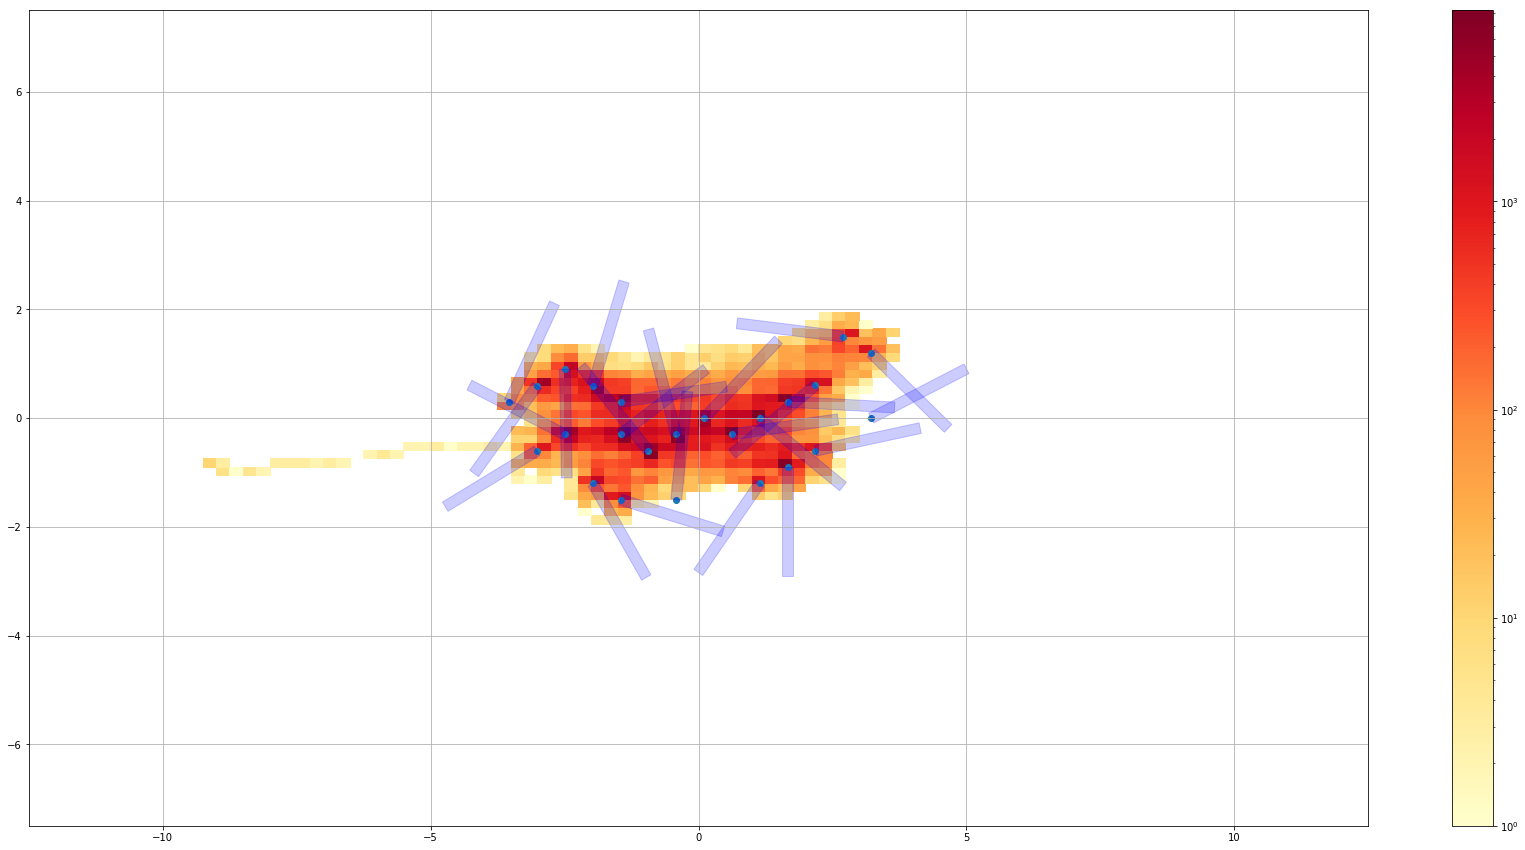

In [62]:
from matplotlib.colors import LogNorm
for v in range(1):
    
    fig = plt.figure(figsize=(30,15))
    ax = fig.add_subplot(111)

    plt.hist2d(visitor_data['Location_x_{}'.format(v+1)][:], visitor_data['Location_z_{}'.format(v+1)][:], bins=100, normed=False, range=[[-12.5,12.5],[-7.5,7.5]], cmap='YlOrRd', norm=LogNorm())
    plt.colorbar()
    plt.grid()
    plot_scene(ax)